In [1]:
import numpy as np
import pandas as pd

from skimage import io
from skimage.filters import threshold_otsu, gaussian
from skimage import measure
from skimage.transform import resize
from skimage.morphology import binary_dilation, binary_opening, binary_closing, ball

import os
from matplotlib import pyplot as plt
import napari
import tifffile
# from threadpoolctl import threadpool_limits

from scipy import spatial
from scipy import ndimage as ndi
from scipy.ndimage import map_coordinates
from scipy.ndimage.morphology import binary_fill_holes
from scipy.integrate import solve_ivp
from scipy import interpolate

from sklearn.preprocessing import PolynomialFeatures, normalize
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import manifold

# from sklearn_extra.cluster import KMedoids

import zarr

import pydeform.sitk_api as pydeform
import itertools
import ray
from tqdm import tqdm
import ants
import SimpleITK as sitk

from vispy import color
from vispy.color import Colormap

import pickle
import xarray as xr

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [160]:
import importlib
from morphotrack import trace
import morphotrack.variables
import morphotrack.points
import morphotrack.track
import morphotrack.binary
import morphotrack.image
import morphotrack.align
import morphotrack.nonlinear_align
import morphotrack.distance
import morphotrack.dtw
importlib.reload(morphotrack.nonlinear_align)


<module 'morphotrack.nonlinear_align' from '/home/tmurakami/src/morphotrack/morphotrack/nonlinear_align.py'>

In [4]:
io_directory = '/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack'
vessel = io.imread(os.path.join(io_directory,'R01_ch561_10um.tif'))

# load autofluorescence/nuclei for segmentation
nuclei = io.imread(os.path.join(io_directory,'R01_ch488_10um.tif'))# autofl_zarr['0'][:]
voxel_size = [10, 10, 10]

# load a mask of a white matter 
white_matter = io.imread(os.path.join(io_directory,'white_matter.tif'))!=0
# white_matter = morphotrack.binary.extract_largest_object_from_binary(white_matter)
# white_matter = binary_opening(white_matter,ball(5))
# white_matter = binary_fill_holes(white_matter)

# load a mask of a layer 1
layer1 = io.imread(os.path.join(io_directory,'l1.tif'))!=0
# layer1 = morphotrack.binary.extract_largest_object_from_binary(layer1)
# layer1 = binary_opening(layer1,ball(5))
# layer1 = binary_fill_holes(layer1)

# segmentated tissue
# background_val = 500
# segmented_tissue = (nuclei>background_val)
# segmented_tissue = morphotrack.binary.extract_largest_object_from_binary(segmented_tissue)
# segmented_tissue = binary_opening(segmented_tissue,ball(5))
# segmented_tissue = io.imread(os.path.join(io_directory,'l1_labkit.tif'))!=2
segmented_tissue = io.imread(os.path.join(io_directory,'tissue_mask.tif'))!=0

# read cellular coordinate
cells_info = pd.read_csv('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/coord_centroids.csv',index_col=0) # the unit is original voxel.
scaling_factor = np.asarray([3,0.65,0.65])
cell_coords = cells_info.loc[:,['centroid-0','centroid-1','centroid-2']] * scaling_factor / 10# convert unit to 10 um for consistency
cell_coords = cell_coords.to_numpy()

# load model
clf = pickle.load(open(os.path.join(io_directory,'model.pkl'), 'rb'))
norm_flow_on_coordinate = morphotrack.points.model_to_norm_flow_func(clf.degree, clf)

In [5]:
# visual sanity check
viewer= napari.Viewer()
viewer.add_image(layer1)
viewer.add_image(white_matter)
viewer.add_image(nuclei)
viewer.add_image(segmented_tissue)

<Image layer 'segmented_tissue' at 0x7f340c7d57c0>

In [6]:
%%time
### selection of the outer most cells.
# # convex hull is not successful. Try alpha shape instead.
# # 750,000 takes ~7 min.
ver, nor = morphotrack.points.cloud_to_alphashape(cell_coords, downsample=10, alpha=0.1, return_normal=True)

CPU times: user 6min 4s, sys: 2.67 s, total: 6min 6s
Wall time: 6min 6s


In [10]:
selection = morphotrack.points.face_selection(ver, nor, norm_flow_on_coordinate(ver), n_clusters=2, cluster_selection='min')
points = ver[selection]

viewer = napari.Viewer()
viewer.add_points(
    ver,
    size=2,
    face_color = 'green',
    edge_width=0,
    symbol='disc',
)
viewer.add_points(
    points,
    size=2,
    face_color = 'white',
    edge_width=0,
    symbol='disc',
)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Points layer 'points' at 0x7f32a77fb2e0>

In [12]:
# np.save('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/surface_points.npy',points)
# points = np.load('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/surface_points.npy')
# seeds_df = pd.DataFrame(ver[selection], columns=['x0','x1','x2'])

## Seeding and extending

In [11]:
polynomial_vectorfield = morphotrack.track.polynomial_vectorfield_generator(clf.coef_, clf.degree)
tracker = morphotrack.track.FieldTracker(polynomial_vectorfield, points) # make a FieldTracker object

# tracing
t_start = 0
t_end = 500
tracker.solve_ode(t_start,t_end)

(pid=3612477) /home/tmurakami/src/morphotrack/morphotrack/track.py:32: RuntimeWarning: overflow encountered in double_scalars
(pid=3612477)   (b * (x0 ** ij_powers[i, 0]) * (x1 ** ij_powers[i, 1]) * (x2 ** ij_powers[i, 2]) for i, b in enumerate(coeff)))
(pid=3612477) /home/tmurakami/src/morphotrack/morphotrack/track.py:31: RuntimeWarning: invalid value encountered in double_scalars
(pid=3612477)   return sum(
(pid=3612510) /home/tmurakami/src/morphotrack/morphotrack/track.py:32: RuntimeWarning: overflow encountered in double_scalars
(pid=3612510)   (b * (x0 ** ij_powers[i, 0]) * (x1 ** ij_powers[i, 1]) * (x2 ** ij_powers[i, 2]) for i, b in enumerate(coeff)))
(pid=3612510) /home/tmurakami/src/morphotrack/morphotrack/track.py:31: RuntimeWarning: invalid value encountered in double_scalars
(pid=3612510)   return sum(
(pid=3612501) /home/tmurakami/src/morphotrack/morphotrack/track.py:32: RuntimeWarning: overflow encountered in double_scalars
(pid=3612501)   (b * (x0 ** ij_powers[i, 0]) * (

In [13]:
# Visualize tracks
position = tracker.t_positions.stack(pos=['time', 'track']).data.T
position[np.isnan(position)] = 0
flow_vector = abs(norm_flow_on_coordinate(position))

flow_img = np.zeros(vessel.shape+(vessel.ndim,))
for i in range(vessel.ndim):
    flow_img[...,i] = morphotrack.image.fill_value_in_range(flow_img[...,i],position.T,flow_vector[:,i])
    flow_img[...,i] = flow_img[...,i]*(segmented_tissue!=0)
    
viewer = napari.Viewer()
viewer.add_image(vessel, contrast_limits=[0,20000], rgb=False, name='sma', colormap='gray', blending='additive')

palette = [
    Colormap([[1.0, 1.0, 1.0, 0.0], [1.0, 0.0, 0.0, 1.0]]),
    Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 1.0, 0.0, 1.0]]),
    Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 0.0, 1.0, 1.0]])]

for i in range(vessel.ndim):
    viewer.add_image(flow_img[...,i], contrast_limits=[0,1], rgb=False, name=i, colormap=palette[i], blending='translucent')
# viewer.add_image(flow_img, rgb=True, contrast_limits=[0,1], name=0,  blending='translucent')
viewer.add_image(segmented_tissue, contrast_limits=[0,2], rgb=False, name='mask', colormap='cyan', blending='additive', multiscale=False, visible=False)

<Image layer 'mask' at 0x7f34b3e6e520>

In [14]:
track = tracker.t_positions
flow = tracker.apply_function_to_position(norm_flow_on_coordinate)

## Count in-kernel cells

In [15]:
%%time
half_thickness = 2.5 # * 10 micrometer. half of the thickness
radius = 10 # * 10 micrometer
kernel_counts = tracker.count_around_position_in_disk_kernel(cell_coords, half_thickness, radius)
kernel_counts = kernel_counts.fillna(0)

CPU times: user 12min 16s, sys: 1min 4s, total: 13min 21s
Wall time: 8min 31s


In [24]:
viewer = napari.Viewer()
viewer.add_image(kernel_counts)

<Image layer 'kernel_counts' at 0x7f346f7be670>

## Filtering with white matter and tissue shape

In [33]:
# get binary mask for gray matter
gray_candidate = (1-white_matter)*segmented_tissue

# get segments where tracks are in gray matter
gray_loc = tracker.fetch_value_in_position(gray_candidate)
gray_loc = gray_loc.astype(float).fillna(0)
gray_loc.data = np.apply_along_axis(lambda a:morphotrack.binary.extract_largest_object_from_binary(a, np.ones(3)), axis=1, arr=gray_loc.data) # extract the longest segment

# make filter based on the size of the segment
filters = []
size_threshold = 50
filters.append(gray_loc.sum(dim='time')>=size_threshold)

# make filter based on one edge is white matter
white_loc = tracker.fetch_value_in_position(white_matter)
white_loc = white_loc.astype(float).fillna(0)
extension_param = 10
temp = gray_loc.copy()
temp.data = np.apply_along_axis(lambda a:binary_dilation(a, np.hstack([np.zeros(extension_param),np.ones(extension_param)])), axis=1, arr=gray_loc.data)
filters.append(((temp.astype(int)-gray_loc.astype(int))*white_loc).sum(dim='time')>0)

# make filter based on inclusion of layer1
l1_loc = tracker.fetch_value_in_position(layer1)
l1_loc = l1_loc.astype(float).fillna(0)
filters.append(l1_loc.sum(dim='time')>0)

# dilate to obtain redundancy for alignment
gray_extension = 40
gray_loc.data = np.apply_along_axis(lambda a:binary_dilation(a, np.hstack([np.zeros(gray_extension),np.ones(gray_extension)])), axis=1, arr=gray_loc.data)

# summarize filters
filters = xr.concat(filters,dim='filt')

In [34]:
# Visualize tracks
position = tracker.t_positions.sel(track=filters.track[filters.all(dim='filt').data].data)
position = position.stack(pos=['time', 'track']).data.T
selection = gray_loc.sel(track=filters.track[filters.all(dim='filt').data].data)
selection = selection.stack(pos=['time', 'track']).data

position[np.isnan(position)] = 0
position[~selection,:] = 0

flow_vector = abs(norm_flow_on_coordinate(position))
flow_img = np.zeros(vessel.shape+(vessel.ndim,))
for i in range(vessel.ndim):
    flow_img[...,i] = morphotrack.image.fill_value_in_range(flow_img[...,i],position.T,flow_vector[:,i])
    flow_img[...,i] = flow_img[...,i]*segmented_tissue
    
viewer = napari.Viewer()
viewer.add_image(vessel, contrast_limits=[0,20000], rgb=False, name='sma', colormap='gray', blending='additive')

palette = [
    Colormap([[1.0, 1.0, 1.0, 0.0], [1.0, 0.0, 0.0, 1.0]]),
    Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 1.0, 0.0, 1.0]]),
    Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 0.0, 1.0, 1.0]])]

for i in range(vessel.ndim):
    viewer.add_image(flow_img[...,i], contrast_limits=[0,1], rgb=False, name=i, colormap=palette[i], blending='translucent')
# viewer.add_image(flow_img, rgb=True, contrast_limits=[0,1], name=0,  blending='translucent')
viewer.add_image(segmented_tissue, contrast_limits=[0,2], rgb=False, name='mask', colormap='cyan', blending='additive', multiscale=False, visible=False)

<Image layer 'mask' at 0x7f34abc6dac0>

## Alignment

### Linear alignment
linearly transform the tracks to fit standard

In [151]:
# get tracks for analysis
track_selection = filters.track[filters.all(dim='filt')]

# create xarray dataset
track_ds = xr.Dataset(data_vars={'Kernel_counts': kernel_counts.isel(track=track_selection), 'Gray_loc': gray_loc.isel(track=track_selection)})
track_ds['Gray_counts'] = track_ds.Kernel_counts * track_ds.Gray_loc

# position and flow for future reference
track_ds['Position'] = tracker.t_positions.isel(track=track_selection.data)
track_ds['Flow'] = flow.isel(track=track_selection.data)
track_ds['Seeds'] = tracker.seeds_xr.isel(track=track_selection.data)


In [152]:
# get a standard as a template of alignment
# std_pos = morphotrack.points.pick_median_nearest_point(track_ds['Seeds'],1)
std_pos = 5555 # or set manually
std_seed = track_ds['Seeds'][std_pos,:].track.data
standard = morphotrack.align.standard_generator(track_ds.Gray_counts,std_seed)

# linear transformation of the tracks to the standard track
args, disps = morphotrack.align.linear_shift_to_standard(track_ds.Gray_counts,std_seed)

# save to track dataset
track_ds['Standard'] = standard
track_ds['Linear_arg'] = args
track_ds['Linear_warped'] = disps

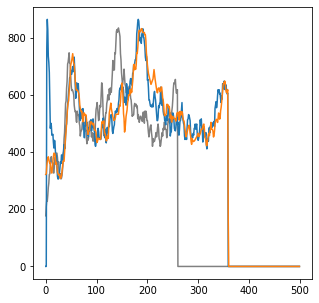

In [153]:
track_ds_02 = xr.open_dataset('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/track_ds.nc').load()

# standard alignment
std_00 = track_ds.Standard.isel(track=0).data
std_02 = track_ds_02.Standard.isel(track=0).data

std_00_02, arg00_02 = morphotrack.nonlinear_align.non_linear_align_1d(std_02,std_00)

fig, axs = plt.subplots(figsize=(5,5))

axs.plot(std_00, c='gray')
axs.plot(std_02)
axs.plot(std_00_02)

In [129]:
viewer = napari.Viewer()
viewer.add_image(track_ds.Gray_counts,colormap='green',blending='additive',visible=False)
viewer.add_image(track_ds.Standard,colormap='green',blending='additive')
viewer.add_image(track_ds.Linear_warped.sel(displacement='t2s'),colormap='magenta',blending='additive')
# labels = viewer.add_labels(np.zeros_like(track_ds.Standard.astype(int)), name='labeling')

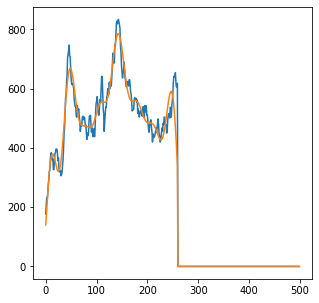

In [157]:
# check FFT filter threshold
threshold = 8e2
fig, axs = plt.subplots(figsize=(5,5))
axs.plot(track_ds.Standard.isel(track=0).data)
fft_filtered = morphotrack.dtw.filter_signal(track_ds.Standard.isel(track=0).data,threshold=threshold)
fft_filtered[track_ds.Standard.isel(track=0).data==0]=0
axs.plot(fft_filtered)

In [155]:
# track_ds_02 = xr.open_dataset('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/track_ds.nc').load()
# # standard alignment
# std_01 = track_ds.Standard.isel(track=0).data
# std_02 = track_ds_02.Standard.isel(track=0).data

# std_02_warped, arg = morphotrack.nonlinear_align.non_linear_align_1d(std_02,std_01)

# plt.plot(std_01)
# plt.plot(std_02)
# plt.plot(std_02_warped)

In [26]:
# if manual alignment is necessary

In [ ]:
# def find_landmark_index(arr1d, std_landmark=20):
#     """
#     """
#     if arr1d.sum()==0:
#         landmark = std_landmark
#     else:
# #     landmarks = std_landmark.copy()
# #     for i in range(1, std_landmark.size-1):
# #         positions = np.where(labels[:,line]==i)[0]
# #         if positions.size != 0:
# #             landmarks[i] = round(positions.mean())
# #         else:
# #             landmarks[i] = std_landmark[i]

### Non-linear alignment
The alignment is further finely tuned by non-linear 1d registration

In [158]:
settings = {
    'pyramid_levels':3,
    'pyramid_stop_level': 0,
    'step_size': [1.0, 1.0, 1.0],
    'block_size': [128,128,128],
    'block_energy_epsilon':1e-7,
    'max_iteration_count':100,
    'constraints_weight':1000.0,
    'regularization_weight': 0.25, # default 0.25
    'regularization_scale': 1.0, # default 1.0
    'regularization_exponent': 2.0, # default 2.0
    'image_slots':[{
            'resampler': 'gaussian',
            'normalize': True,
            'cost_function':[
                {
                    'function':'ncc',
                    'weight':1.0,
                    'radius':21
                }
            ]
        }]
}

In [161]:
non_linear_args = morphotrack.nonlinear_align.track_wise_aligner(track_ds.Standard.data, track_ds.Linear_warped.sel(displacement='t2s').data,fft_threshold=threshold, settings=settings)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6105/6105 [2:27:00<00:00,  1.44s/it]


In [162]:
# store non linear displacement in xarray
non_linear_arg_xr = track_ds.Linear_arg.copy()
non_linear_arg_xr[:] = np.asarray(non_linear_args[::-1])
track_ds['Nonlinear_arg'] = non_linear_arg_xr

# make total displacement 
comp_disps = []
for x in track_ds.Nonlinear_arg.displacement.data:
    comp_disps.append(morphotrack.align.composite_displacement(track_ds.Linear_arg.sel(displacement=x),track_ds.Nonlinear_arg.sel(displacement=x)))

# store total displacement in xarray
total_arg_xr = track_ds.Linear_arg.copy()
total_arg_xr[:] = np.asarray(comp_disps)
track_ds['Total_arg'] = total_arg_xr

# make total warped tracks
s2t_non_linear_warped = morphotrack.align.positional_mapping(track_ds.Standard, track_ds.Total_arg.sel(displacement='s2t'))
t2s_non_linear_warped = morphotrack.align.positional_mapping(track_ds.Gray_counts, track_ds.Total_arg.sel(displacement='t2s'))

# store total warp in xarray
total_warp_xr = track_ds.Linear_arg.copy()
total_warp_xr[:] = np.asarray([s2t_non_linear_warped, t2s_non_linear_warped])
track_ds['Total_warped'] = total_warp_xr

In [163]:
viewer = napari.Viewer()
viewer.add_image(track_ds.Gray_counts,colormap='green',blending='additive',visible=False)
viewer.add_image(track_ds.Standard,colormap='green',blending='additive')
viewer.add_image(track_ds.Total_warped.sel(displacement='t2s'),colormap='magenta',blending='additive')
viewer.add_image(track_ds.Total_warped.sel(displacement='s2t'),colormap='magenta',blending='additive',visible=False)

<Image layer 'Image [3]' at 0x7f331815e580>

## local flux map. quality metrics.
### quality metrics and filitering

In [165]:
std = track_ds.Total_warped.sel(displacement='t2s',track=std_seed)# track_ds.Standard.sel(track=std_seed)

# get cosine similarities
cs = np.apply_along_axis(morphotrack.track.cosine_similarity, 1, track_ds.Total_warped.sel(displacement='t2s'), std)
# get mutual information
mi = np.apply_along_axis(morphotrack.track.mutual_information, 1, track_ds.Total_warped.sel(displacement='t2s'), std)

# thresholding with otsu
cs_thresh = threshold_otsu(cs)
mi_thresh = threshold_otsu(mi)

# # selection of tracks
# select_tracks = track_ds.track[(cs>=cs_thresh)&(mi>=mi_thresh)]
# selected_track_ds = track_ds.sel(track=select_tracks)

# save in track_ds
qc_array = xr.DataArray(np.stack([cs,mi]).T,
                        coords={'track': track_ds.track,
                             'metrics': ['cs','mi']},
                        dims=['track', 'metrics'],
                        attrs=dict(cs_thresh=cs_thresh,mi_thresh=mi_thresh)
                        )

track_ds['Similarity'] = qc_array

In [164]:
# viewer = napari.Viewer()
# viewer.add_image(selected_track_ds.Gray_counts,colormap='green',blending='additive',visible=False)
# viewer.add_image(selected_track_ds.Standard,colormap='green',blending='additive')
# viewer.add_image(selected_track_ds.Total_warped.sel(displacement='t2s'),colormap='magenta',blending='additive')
# viewer.add_image(selected_track_ds.Total_warped.sel(displacement='s2t'),colormap='magenta',blending='additive',visible=False)

In [102]:
# img = morphotrack.image.visualize_in_original_space(selected_track_ds.Position, selected_track_ds.Total_arg.sel(displacement='s2t'), vessel.shape)

# viewer = napari.Viewer()
# viewer.add_image(img,colormap='turbo',blending='additive')
# viewer.add_image(nuclei,colormap='gray',blending='additive')

### compression map

In [166]:
# convert position to distance
dist = morphotrack.distance.position2distance_xr(track_ds.Position)

# adjust positions to match the standard, and convert the positions to distance.
position_in_standard = morphotrack.distance.map2standard_vectorspace_xr(track_ds.Total_arg.sel(displacement='s2t'),track_ds.Position.sel(track=std_seed))
dist_in_standard = morphotrack.distance.position2distance_xr(position_in_standard)

# take moving average and get log fold changes. this produces compression map.
window = 10
logfc = morphotrack.distance.logFC_distance_t2s(dist_in_standard, dist_in_standard.sel(track=std_seed), window)
logfc = logfc.assign_attrs(window=window)
track_ds['LogCompression'] = logfc

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning:

divide by zero encountered in log2

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning:

invalid value encountered in log2



In [167]:
viewer = napari.Viewer()
viewer.add_image(logfc,contrast_limits=[-2,2],colormap='twilight',blending='additive')

<Image layer 'logfc' at 0x7f33cae37970>

In [59]:
img = morphotrack.image.visualize_in_original_space(track_ds.Position, logfc, vessel.shape)

viewer = napari.Viewer()
viewer.add_image(img,contrast_limits=[-2,2],colormap='twilight',blending='additive')
viewer.add_image(nuclei,colormap='gray',blending='additive')

<Image layer 'nuclei' at 0x7fc4b71aeb20>

### local flux map

In [168]:
layer_position = []
for tr in track_ds.track.data:
    interp_position = track_ds.Position.sel(track=tr).interp(time=track_ds.Total_arg.sel(displacement='t2s').sel(track=tr).data)
    interp_position = interp_position.assign_coords(time=np.arange(t_start,t_end))
    layer_position.append(interp_position)
layer_position = xr.concat(layer_position,dim='track')
layer_position = layer_position.rename(time='warped_time')

In [169]:
local_flux = []
for t in tqdm(layer_position.warped_time.data):
    local_flux.append(morphotrack.points.get_local_flux(layer_position.sel(warped_time=t).data, norm_flow_on_coordinate, radius))
local_flux = np.stack(local_flux)
local_flux = xr.DataArray(local_flux,
                          coords={'warped_time': layer_position.warped_time,
                                  'track': layer_position.track},
                          dims=['warped_time', 'track'],
                          attrs=dict(radius=radius)
                          )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 29.00it/s]


In [170]:
track_ds['Distance'] = dist.fillna(0).cumsum(dim='time')
track_ds['Warped_position'] = layer_position
track_ds['Local_flux'] = local_flux

In [171]:
reference_time = 140
pos = track_ds.Warped_position.sel(warped_time=reference_time).data
local_flux = track_ds.Local_flux.sel(warped_time=reference_time).data
color_vis = morphotrack.image.vector_color_mapping(local_flux,colormap='plasma')

viewer = napari.Viewer()
viewer.add_image(nuclei,colormap='gray',blending='additive')
viewer.add_points(
    pos,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc'
)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Points layer 'pos' at 0x7f335c7c8460>

In [172]:
track_ds.to_netcdf(os.path.join(io_directory,"track_ds_fft.nc"))

In [173]:
layer_distances = []
for t in tqdm(track_ds.time.data):
    ref_time_in_track = ((track_ds.Total_arg.sel(displacement='t2s') - t)**2).argmin(dim='time')
    layer_distance = track_ds.Distance.data[tuple(np.arange(ref_time_in_track.size)),tuple(ref_time_in_track.data)]
    layer_distance = xr.DataArray(layer_distance,coords={'track':track_ds.track,'time':t},dims=['track']) # xr.DataArray(layer_distance,coords={'track':track_ds.track},dims=['track'])
    layer_distances.append(layer_distance)
layer_distances = xr.concat(layer_distances,dim='time')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 98.37it/s]


In [174]:
# this is for manual removal of the mis-aligned tracks
import hdbscan
from sklearn.preprocessing import StandardScaler

clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5)
# reference_time = 130
ld = layer_distances.sel(time=reference_time).data
pos = track_ds.Warped_position.sel(warped_time=reference_time).data
features = pos#np.hstack([pos,ld[:,np.newaxis]])
scaler = StandardScaler().fit(features)

clusterer.fit(scaler.transform(features))
cluster_label = clusterer.labels_

color_vis = morphotrack.image.vector_color_mapping(clusterer.labels_,colormap='plasma')

viewer = napari.Viewer()
viewer.add_image(nuclei,colormap='gray',blending='additive')
for c in np.unique(cluster_label):
    selector = (cluster_label==c)
    viewer.add_points(
        pos[selector],
        size=10,
        face_color = color_vis[selector],
        edge_width=0,
        name=str(c),
        symbol='disc'
    )

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numer

In [175]:
outliers = np.asarray([-1,0,3,4])
manual_filt = xr.DataArray(~np.isin(cluster_label,outliers),coords={'track':track_ds.track},dims=['track'])
similarity_filt = xr.DataArray((cs>=cs_thresh)&(mi>=mi_thresh),coords={'track':track_ds.track},dims=['track'])
filter_xr = xr.concat([manual_filt,similarity_filt],dim='filt')
filter_xr.to_netcdf(os.path.join(io_directory,"filter_da_fft.nc"))

In [176]:
# tes = selected_track_ds.Total_warped.sel(displacement='t2s').data
# tes1 = (tes - tes.mean(axis=0)) / tes
# viewer = napari.Viewer()
# viewer.add_image(selected_track_ds.Total_warped.sel(displacement='t2s'),colormap='green',blending='additive')
# viewer.add_image(tes1,colormap='magenta',blending='additive')

In [ ]:
# from scipy.stats import zscore
# # trim = tes = t_end - np.argmax(track_ds.Gray_loc.sel(track=std_seed).data[::-1])
# aligned = track_ds.Total_warped.sel(displacement='t2s').data
# # aligned_zscore = zscore(track_ds.Total_warped.sel(displacement='t2s').data.T,axis=0)
# pca = PCA().fit(aligned)
# pcs = pca.transform(aligned)
# pc1 = pcs[:,0]
# pc2 = pcs[:,1]

# fig, axs = plt.subplots(figsize=(5,5))
# axs.scatter(pc1,pc2,s=1)

In [346]:
# reference_time = 100
# pos = track_ds.Warped_position.sel(warped_time=reference_time).data
# ld = layer_distances.sel(time=reference_time).data
# color_vis = morphotrack.track.vector_color_mapping(clusterer.labels_,colormap='plasma')

# viewer = napari.Viewer()
# viewer.add_image(nuclei,colormap='gray',blending='additive')
# viewer.add_points(
#     pos,
#     size=10,
#     face_color = color_vis,
#     edge_width=0,
#     symbol='disc'
# )

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Points layer 'pos' at 0x7f16ed98e220>

In [334]:
# make feature matrix for isolation forest
# from sklearn.ensemble import IsolationForest
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# from sklearn.neighbors import LocalOutlierFactor

reference_time = 100
ld = layer_distances.sel(time=reference_time).data
pos = track_ds.Warped_position.sel(warped_time=reference_time).data
# features = np.hstack([pos,ld[:,np.newaxis]])
# clf = IsolationForest(random_state=42).fit(features)
# tes = clf.predict(features)
spline = interpolate.RBFInterpolator(pos, ld, smoothing=1000.0, kernel='thin_plate_spline')
fit_ld = spline(pos)
cf = np.sqrt((fit_ld-ld)**2)


In [312]:
# sp_fit = np.vstack([tesx,tesy,tesz]).T

# viewer = napari.Viewer()
# viewer.add_image(nuclei,colormap='gray',blending='additive')
# viewer.add_points(
#     sp_fit,
#     size=10,
#     face_color = 'white',
#     edge_width=0,
#     symbol='disc'
# )
# reference_time = 100
# pos = track_ds.Warped_position.sel(warped_time=reference_time).data
# viewer.add_points(
#     pos,
#     size=10,
#     face_color = 'green',
#     edge_width=0,
#     symbol='disc'
# )

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Points layer 'pos' at 0x7f17854fdfa0>

In [335]:
pos = track_ds.Warped_position.sel(warped_time=reference_time).data
color_vis = morphotrack.track.vector_color_mapping(cf,colormap='plasma')

viewer = napari.Viewer()
viewer.add_image(nuclei,colormap='gray',blending='additive')
viewer.add_points(
    pos,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc'
)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Points layer 'pos' at 0x7f173c13c2e0>